# 理论和实践，要相结合。Coding! Coding! Coding!
## 林彪元帅说学习毛主席语录要“带着问题学，活学活用，学用结合，急用先学，立竿见影”。


---

### 因子实战 第十集 
# 回测 Backtesting 代码习题课

### 🎬 @大导演哈罗德
### 🏛 香港中文大学 金融工程 本科
### 📈 即将前往美国金融工程硕士之路（已经获得录取）
### 🌐 [关注我的Bilibili，看所有人都能听得懂的量化学习内容！](https://space.bilibili.com/629573485)

🌟🌟🌟 我有一个梦想，就是让量化变成不再是束之高阁的灵丹妙药，而是让散户投资者认识市场风险最好的工具 #哈罗德的量化频道 🌟🌟🌟

---

In [3]:
import pandas as pd
import numpy as np
from statsmodels.api import OLS,add_constant

In [4]:
def align_factor(factors):
	'''
	将factors,按照aim_factor完成对齐,factors=[aim_factor,factor1,factor2]
	以第一个df为标准对齐
	需要考虑第一个factor有的日期,后面的factor可能会没有,所以,第一步应该是确保factor[1:]中的日期要有,没有的话向前填充
	'''
	# 先对齐日期
	index = factors[0].index
	columns = factors[0].columns
	result = [factors[0]]
	for i in factors[1:]:
		to_append = i.reindex(index=index,method='pad')
		to_append = to_append.reindex(columns=columns)
		result.append(to_append)
	return result

In [18]:
def FactorIC(factor1,factor2,min_valid_num=0):
	'''
	计算factor1与factor2的横截面相关系数(Pearson,Spearman)
	:param factor1(pd.DataFrame):因子1
	:param factor2(pd.DataFrame):因子2
	:param min_valid_num(float):横截面上计算一期相关系数最小的样本个数要求,默认最小是1
	:return pearson_corr,spearman_corr
	'''
	factor1.replace({None:np.nan},inplace=True)
	factor1=factor1.astype(float)
	factor2.replace({None:np.nan},inplace=True)
	factor2=factor2.astype(float)	
	
	factor1_sum = factor1.notnull().sum(axis=1)
	factor1.loc[factor1_sum<min_valid_num,:]=np.nan
	factor2_sum = factor2.notnull().sum(axis=1)
	factor2.loc[factor2_sum<min_valid_num,:]=np.nan
	
	pearson_corr=factor1.corrwith(factor2,axis=1)	
	spearman_corr=factor1.rank(axis=1).corrwith(factor2.rank(axis=1),axis=1)
	
	return pearson_corr,spearman_corr

In [19]:
def FactorGroup(factor,split_method='average',split_num=5,industry_factor=None,limit_df=None):
	'''
	将因子进行分类,按照行分类。
	:param factor:要分类的因子,或者打分
	:param split_method:默认为等比例分组,'average',还可以有'largest','smallest','largest_ratio','smallest_ratio'
	:param split_num:若split_method=='average',则等分split_num组,若为'largest',则最大n个,若'smallest',则最小n个,若largest_ratio,则最大百分比,若smallest_ratio,则最小百分比
	:param industry_factor(pd.DataFrame or None):行业因子
	:param limit_df(pd.DataFrame or NOne):None或者TrueFalse构成的df,来自于FactorTool_GetLimitDf的结果
	:return:factor_split_result, df
	'''
	if limit_df is not None:
		[factor,limit_df] = align_factor([factor,limit_df])
		limit_df = limit_df.fillna(value=True).astype('bool')
		factor = factor[limit_df]
		
	if industry_factor is None:
		industry_factor = pd.DataFrame(index=factor.index,columns=factor.columns,data='Market')
		industry_factor = industry_factor[factor.notnull()].astype('object')
	else:
		[factor,industry_factor] = align_factor([factor,industry_factor])
		industry_factor = industry_factor.astype('object')
		industry_factor = industry_factor.fillna(value='others')
		industry_factor = industry_factor[factor.notnull()]
		
	data = pd.DataFrame(index=pd.MultiIndex.from_product([factor.index,factor.columns],names=['date','asset']))
	data['group'] = industry_factor.stack()
	data['factor'] = factor.stack()
	data = data.dropna(subset=['group'])
	
	data_factor_array = data['factor'].values
	data_final_split = np.full((len(data_factor_array),),np.nan)
	
	grouper = [data.index.get_level_values('date'),'group']
	data_groupby = data.groupby(grouper)
	data_groupby_indices = data_groupby.indices
	data_groupby_indices = list(data_groupby_indices.values())
	
	def auxilary_get_split_array(data_factor_array,data_final_split,data_groupby_indices,split_method,split_num):
		def quantile_split(_this_split_result,_this_array,_split_percentile):
			split_value = np.nanpercentile(_this_array,_split_percentile)
			split_value[0] -= 1
			split_value[-1] += 1
			for i in range(len(split_value)-1):
				_this_split_result[(_this_array<=split_value[i+1])&(_this_array>split_value[i])] = i
			return _this_split_result
			
		if split_method=='average':
			split_percentile = np.linspace(0,100,split_num+1)
		elif split_method=='largest_ratio':
			split_percentile = np.array([0,100-split_num*100,100])
		elif split_method=='smallest_ratio':
			split_percentile = np.array([0,split_num*100,100])
		
		for this_group_place in range(len(data_groupby_indices)):
			this_indice_place = data_groupby_indices[this_group_place]
			this_factor_array = data_factor_array[this_indice_place]
			this_split_result = data_final_split[this_indice_place]
			# if split_method in ['average','largest','smallest']:
			if split_method =='average':
				this_data_final_split = quantile_split(this_split_result,this_factor_array,split_percentile)
				data_final_split[this_indice_place] = this_data_final_split
			elif split_method=='smallest':
				this_factor_array_sort = np.sort(this_factor_array[~np.isnan(this_factor_array)])
				split_value = this_factor_array_sort[min(len(this_factor_array_sort)-1,split_num-1)]			
				if len(split_value)>0:
					this_split_result[this_factor_array<=split_value]=0
					this_split_result[this_factor_array>split_value]=1
					data_final_split[this_indice_place] = this_split_result
			elif split_method=='largest':
				this_factor_array_sort = np.sort(this_factor_array[~np.isnan(this_factor_array)])[::-1]
				split_value = this_factor_array_sort[min(len(this_factor_array_sort)-1,split_num-1)]
				if len(split_value)>0:
					this_split_result[this_factor_array<split_value] = 0
					this_split_result[this_factor_array>=split_value] = 1
					data_final_split[this_indice_place] = this_split_result
		return data_final_split
	
	data_final_split = auxilary_get_split_array(data_factor_array,data_final_split,data_groupby_indices,split_method,split_num)	
	data.loc[:,'factor'] = data_final_split	
	final_data = data['factor'].unstack().reindex(index=factor.index,columns=factor.columns)
	
	return final_data

In [7]:
# 简单的中性化框架
def FactorPurify(factor,elifactor):
    # elifactor = [pd.DataFrame(),pd.DataFrame()...]
    new_elifactor = []
    for f in elifactor:
        new_elifactor.append(f.reindex(index = factor.index,columns = factor.columns))
    factor_res = pd.DataFrame()
    for idx in factor.dropna(how = 'all',axis=0).index:
        this_factor = factor.loc[idx,:]
        for f in new_elifactor:
            this_elifactor = f.loc[idx,:]
            this_factor = pd.concat([this_factor,this_elifactor],axis=1)
        this_factor = this_factor.astype(float).dropna()
        model = OLS(this_factor.iloc[:,0],add_constant(this_factor.iloc[:,1:]))
        res = model.fit()
        factor_res = pd.concat([factor_res,res.resid.rename(idx)],axis=1)
    return factor_res.T

In [8]:
sw_ind = pd.read_pickle('数据/IndexComponent_SWN_I.txt')
pe = pd.read_pickle('数据/StockQuote_PEttm.txt')
stock_close = pd.read_pickle('数据/StockQuote_ClosePrice_BackwardAdj.txt')
stock_open = pd.read_pickle('数据/StockQuote_OpenPrice_BackwardAdj.txt')

In [11]:
pe

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
19910703,NaN,NaN,26.3956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910704,NaN,NaN,23.0497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910705,NaN,NaN,26.0239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910708,NaN,NaN,25.4662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910710,NaN,NaN,22.3062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231225,3.6777,6.4041,NaN,NaN,NaN,27.5205,115.2904,NaN,23.7738,NaN,...,30.4278,28.9206,45.0626,20.5434,20.6684,103.6429,15.2196,21.0074,21.2969,NaN
20231226,3.6417,6.3232,NaN,NaN,NaN,27.0856,114.3297,NaN,23.6100,NaN,...,32.9288,28.5608,43.7311,20.9607,20.6773,98.7415,15.5923,21.7679,21.1019,NaN
20231227,3.6497,6.3232,NaN,NaN,NaN,28.2660,114.8100,NaN,23.8148,NaN,...,34.4277,29.7643,42.2734,20.5054,20.5339,100.7401,16.0228,22.5008,21.4919,NaN
20231228,3.7818,6.5408,NaN,NaN,NaN,28.2660,116.9717,NaN,24.1014,NaN,...,34.5728,30.1489,42.4456,21.9660,20.6773,98.7415,16.0146,21.7073,22.2268,NaN


In [10]:
ep = 1/pe
ep.replace(np.inf, np.nan, inplace = True) #  计算EPttm并去除无限大的值
ep.replace(-np.inf, np.nan, inplace = True) #  计算EPttm并去除无限大的值
dEP = ep.diff(60) # dEP因子是EP因子的六十日delta
dEP

,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
19910703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19910710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231225,0.043437,0.017033,NaN,NaN,NaN,0.001129,-0.001517,NaN,-0.004096,NaN,...,NaN,-0.015909,-0.010865,-0.042533,NaN,NaN,NaN,NaN,NaN,NaN
20231226,0.046333,0.016360,NaN,NaN,NaN,0.001384,-0.000954,NaN,-0.003849,NaN,...,NaN,-0.015474,-0.010601,-0.043996,NaN,NaN,NaN,NaN,NaN,NaN
20231227,0.044274,0.013092,NaN,NaN,NaN,-0.000749,-0.001089,NaN,-0.004759,NaN,...,NaN,-0.018160,-0.012258,-0.044454,NaN,NaN,NaN,NaN,NaN,NaN
20231228,0.027114,0.004666,NaN,NaN,NaN,-0.000749,-0.001132,NaN,-0.006583,NaN,...,NaN,-0.018459,-0.013525,-0.048912,NaN,NaN,NaN,-0.029005,NaN,NaN


In [13]:
monthly_trading_day = pd.read_pickle('数据/monthly_trading_day.pkl')
monthly_trading_day['start_date'] = pd.to_datetime(monthly_trading_day['start_date'], format='%Y%m%d')
monthly_trading_day['end_date'] = pd.to_datetime(monthly_trading_day['end_date'], format='%Y%m%d')

start_date = pd.to_datetime('20120101', format='%Y%m%d')
end_date = pd.to_datetime('20231231', format='%Y%m%d')

filtered_trading_days = monthly_trading_day.loc[(monthly_trading_day['end_date'] >= start_date) & (monthly_trading_day['end_date'] <= end_date)]
filtered_trading_days

,start_date,end_date
24,2012-01-04,2012-01-31
25,2012-02-01,2012-02-29
26,2012-03-01,2012-03-30
27,2012-04-05,2012-04-27
28,2012-05-02,2012-05-31
...,...,...
162,2023-07-03,2023-07-31
163,2023-08-01,2023-08-31
164,2023-09-01,2023-09-28
165,2023-10-09,2023-10-31


In [14]:
# 回测周期：2012-01-01至2023-12-31
# change index into datetime
dEP.index = pd.to_datetime(dEP.index)
dEP_monthly = dEP.reindex(index = filtered_trading_days.end_date) # 按月抽样得到dEP的因子值
dEP_monthly


,000001.SZ,000002.SZ,000003.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,...,873570.BJ,873576.BJ,873593.BJ,873665.BJ,873679.BJ,873693.BJ,873703.BJ,873726.BJ,873833.BJ,T00018.SH
end_date,,,,,,,,,,,,,,,,,,,,,
2012-01-31,0.002481,0.002968,NaN,-0.005549,-0.000836,0.003023,0.001183,0.000250,0.003496,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-29,-0.008819,-0.014278,NaN,0.000517,0.000000,-0.048998,-0.006231,0.000168,0.006528,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-30,0.009866,0.011612,NaN,-0.000039,0.000000,-0.075154,-0.010442,NaN,0.002593,0.000081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-27,0.024902,0.009117,NaN,0.000090,-0.011260,-0.026038,-0.008362,NaN,-0.005099,0.003222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-31,0.035999,0.013286,NaN,0.000321,-0.011072,-0.006224,-0.000973,NaN,-0.006213,0.003018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,0.000320,-0.006076,NaN,NaN,NaN,-0.005207,NaN,NaN,-0.001222,NaN,...,NaN,NaN,-0.002515,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,0.011596,-0.010884,NaN,NaN,NaN,-0.030556,NaN,NaN,0.005729,NaN,...,NaN,NaN,0.009349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-28,0.016771,0.002706,NaN,NaN,NaN,-0.021728,NaN,NaN,0.004374,NaN,...,NaN,0.011647,0.005304,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
famafrench = pd.read_excel("数据/STK_MKT_THRFACDAY.xlsx")
famafrench = famafrench[famafrench['MarkettypeID'] == "P9706"] # 9706：沪深A股市场（不包含科创板、创业板）
famafrench = famafrench.reset_index(drop= True)
famafrench = famafrench.set_index("TradingDate").loc["2012-01-01" : '2023-12-31'][['RiskPremium2', "SMB2", "HML2"]]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [29]:
famafrench

,RiskPremium2,SMB2,HML2
TradingDate,,,
2012-01-04,-0.016205,-0.004502,0.00939
2012-01-05,-0.013403,-0.027523,0.01463
2012-01-06,0.00707,-0.002101,0.000992
2012-01-09,0.030277,0.008748,-0.010063
2012-01-10,0.028804,0.006326,-0.014061
...,...,...,...
2023-12-25,0.00202,-0.00887,-0.001847
2023-12-26,-0.005552,-0.005357,0.004727
2023-12-27,0.0064,0.002296,0.002342


In [ ]:
ep = 1/pe


In [26]:
# change index into datetime
stock_close.index = pd.to_datetime(stock_close.index)
stock_open.index = pd.to_datetime(stock_open.index)
stock_ret_monthly = stock_close.reindex(index = filtered_trading_days.end_date).pct_change() #计算股票每月收益
stock_ret_monthly_nextopen = stock_open.shift(-1).reindex(filtered_trading_days.end_date).pct_change()

def simple_factor_test(factor,use_data = 'this_close'):
    if use_data=='this_close':
        this_ret_data = stock_ret_monthly.shift(-1)
    else: 
        this_ret_data = stock_ret_monthly_nextopen.shift(-1)
    ic,rankic = FactorIC(factor,this_ret_data) # 计算因子的ic,rankic序列
    factor_group = FactorGroup(factor)
    condata = pd.concat([factor_group.unstack(),this_ret_data.unstack()],axis=1).dropna().reset_index()
    condata.columns =['stockcode','date','group_id','ret']
    group_ret = condata.groupby(['date','group_id'])['ret'].mean().unstack()
    return ic,rankic,group_ret

/var/folders/md/wt8g61857ld_20f_r6rn4nk40000gn/T/ipykernel_94947/854634429.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  stock_ret_monthly = stock_close.reindex(index = filtered_trading_days.end_date).pct_change() #计算股票每月收益
/var/folders/md/wt8g61857ld_20f_r6rn4nk40000gn/T/ipykernel_94947/854634429.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  stock_ret_monthly_nextopen = stock_open.shift(-1).reindex(filtered_trading_days.end_date).pct_change()


In [23]:
ic,rankic,group_ret  = simple_factor_test(dEP_monthly)

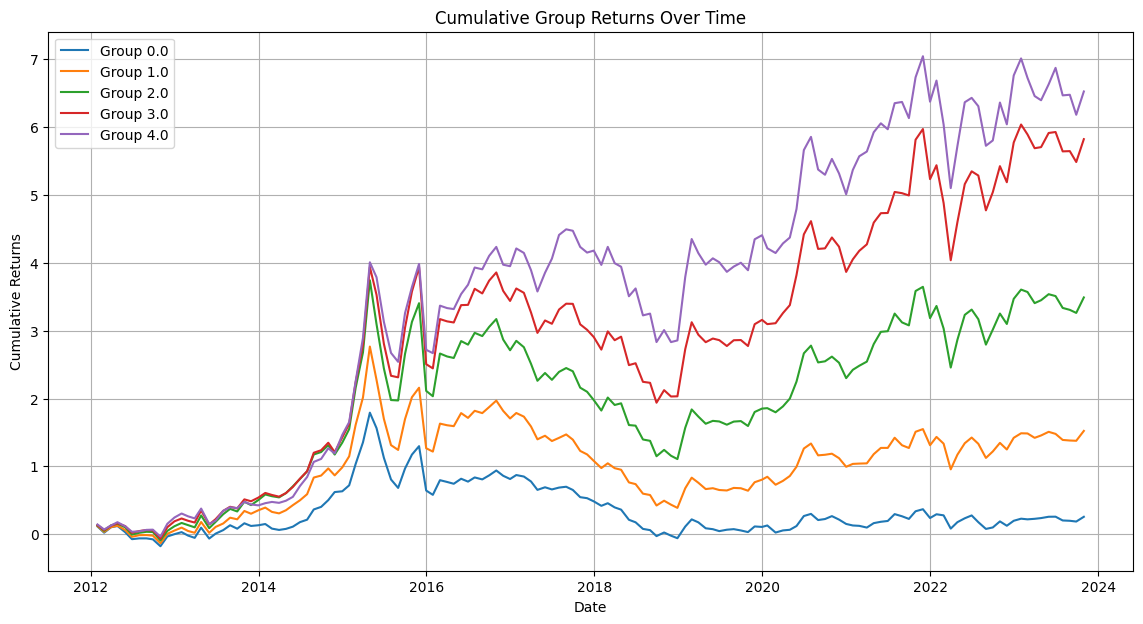

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 转换收益率为累积收益率
cumulative_returns = (1 + group_ret).cumprod() - 1

# 绘制累积收益率
plt.figure(figsize=(14, 7))
for column in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[column], label=f'Group {column}')

plt.title('Cumulative Group Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()
